In [2]:
# Installing required library
!pip install playwright

   ---------------------------------------- 0.0/29.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/29.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/29.8 MB 1.1 MB/s eta 0:00:28
   ---------------------------------------- 0.1/29.8 MB 1.1 MB/s eta 0:00:28
   ---------------------------------------- 0.1/29.8 MB 744.7 kB/s eta 0:00:40
   ---------------------------------------- 0.1/29.8 MB 744.7 kB/s eta 0:00:40
   ---------------------------------------- 0.2/29.8 MB 857.5 kB/s eta 0:00:35
   ---------------------------------------- 0.2/29.8 MB 857.5 kB/s eta 0:00:35
   ---------------------------------------- 0.2/29.8 MB 654.3 kB/s eta 0:00:46
   ---------------------------------------- 0.3/29.8 MB 744.2 kB/s eta 0:00:40
   ---------------------------------------- 0.3/29.8 MB 744.2 kB/s eta 0:00:40
   ---------------------------------------- 0.4/29.8 MB 818.3 kB/s eta 0:00:36
   ---------------------------------------- 0.4/29.8 MB 818.3 kB/s eta 0:0

In [1]:
# Importing required libraries.

from bs4 import BeautifulSoup
from playwright.async_api import async_playwright
import pandas as pd
import asyncio
import time
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
url = 'https://www.gofundme.com/discover'

In [3]:
async def show_all_categories(page):
    """Make sure all categories are loaded on the page"""
    try:
        show_all_button = await page.query_selector('text=Show more categories')
        if show_all_button:
            await show_all_button.click()
            print("All categories loaded.")
    except Exception as e:
        print(f"Error loading categories: {e}")

In [4]:
async def get_category_links(page):
    """Get all category links from the url"""
    content = await page.content()
    soup = BeautifulSoup(content, 'html.parser')   
    # Find all sections with the category class
    sections = soup.find_all('section', class_='discover-search-hits_categorySectionWrapper__HOmjZ')
    CATEGORIES = []
    for section in sections:
        # Find all links within this section
        for a in section.find_all('a', class_='hrt-tertiary-button hrt-tertiary-button--inline hrt-base-button', href=True):
            category_link = a['href']  # Extract the href attribute
            full_link = url[:25] + category_link  # Construct the full link
            CATEGORIES.append(full_link)  # Add to the list of categories

    return CATEGORIES

In [5]:
async with async_playwright() as p:
    browser = await p.chromium.launch()
    page = await browser.new_page()
    await page.goto(url,timeout = 80000)
    await show_all_categories(page)
    category_links = await get_category_links(page)
    print(f"\nTotal {len(category_links)} CATEGORIES\n")
    for i in category_links:
        print(i)
    await browser.close()

All categories loaded.

Total 18 CATEGORIES

https://www.gofundme.com//discover/medical-fundraiser
https://www.gofundme.com//discover/memorial-fundraiser
https://www.gofundme.com//discover/emergency-fundraiser
https://www.gofundme.com//discover/charity-fundraiser
https://www.gofundme.com//discover/education-fundraiser
https://www.gofundme.com//discover/animal-fundraiser
https://www.gofundme.com//discover/environment-fundraiser
https://www.gofundme.com//discover/business-fundraiser
https://www.gofundme.com//discover/community-fundraiser
https://www.gofundme.com//discover/competition-fundraiser
https://www.gofundme.com//discover/creative-fundraiser
https://www.gofundme.com//discover/event-fundraiser
https://www.gofundme.com//discover/faith-fundraiser
https://www.gofundme.com//discover/family-fundraiser
https://www.gofundme.com//discover/sports-fundraiser
https://www.gofundme.com//discover/travel-fundraiser
https://www.gofundme.com//discover/volunteer-fundraiser
https://www.gofundme.com//

There are total of 18 fundraising categories in gofundme website.

In [6]:
async def show_more_campaigns(page):
    """Show more campaigns"""
    try:
        while True:
            show_more_button = await page.query_selector('text=Show more')
            if show_more_button:
                await show_more_button.click()
                await page.wait_for_timeout(2000)  # Wait 2 seconds to load more campaigns
            else:
                break
    except Exception as e:
        print(f"Error loading more campaigns: {e}")

In [7]:
async def get_campaign_links(page):
    """Get individual campaign links"""
    content = await page.content()
    soup = BeautifulSoup(content, 'html.parser')
    sections  = soup.find_all('section', class_='discover-search-hits_categorySectionWrapper__HOmjZ')
    CAMPAIGNS = []
    for section in sections:
        # Find all links within this section
        for a in section.find_all('a', class_='hrt-action-card hrt-base-button', href=True):
            campaign_link = a['href']  # Extract the href attribute
            full_link = url[:25] + campaign_link  # Construct the full link
            CAMPAIGNS.append(full_link)
            
    return CAMPAIGNS        

In [8]:
def save_links(all_links, category_names):
    """Create dataframe from all campaign links with its corresponding category name
       and save it in the form of CSV file"""
    link_category = pd.DataFrame({
        'campaign_link': all_links,
        'category': category_names})

    link_category.to_csv("all_links.csv", encoding="utf-8", index=True)
    print("All links have been saved successfully!!")

In [9]:
async def load_campaign(page,category_links):
    """collect/fetch all fundraising campaigns for each category"""
    
    all_links = []
    category_names = []
    
    for i in tqdm(category_links):
        await page.goto(i,timeout = 80000)
        await page.wait_for_timeout(3000)
        try:
            await show_more_campaigns(page)
        except Exception as e:
            print(f"Error loading campaigns: {e}")
            continue
        finally:
            campaign_links = await get_campaign_links(page)
            all_links      = all_links + campaign_links
            category_names = category_names + len(campaign_links)*[i.split('/')[-1]]
            
    return all_links, category_names 

In [10]:
async with async_playwright() as p:
    browser = await p.chromium.launch()
    page = await browser.new_page()
    all_links, category_names = await load_campaign(page,category_links)
    save_links(all_links, category_names)
    await browser.close()

100%|████████████████████████████████████████| 18/18 [1:39:21<00:00, 331.17s/it]


All links have been saved successfully!!


All fundraising campaign links have been saved in the CSV file by name 'all_links.csv'

In [12]:
# Reading the all_links.csv file 
all_links_df = pd.read_csv('all_links.csv',usecols=[1,2])
all_links_df.head()

,campaign_link,category
0,https://www.gofundme.com//f/support-charlee-ci...,medical-fundraiser
1,https://www.gofundme.com//f/camnjacis-recovery...,medical-fundraiser
2,https://www.gofundme.com//f/support-the-mier-f...,medical-fundraiser
3,https://www.gofundme.com//f/get-ryan-contreras...,medical-fundraiser
4,https://www.gofundme.com//f/support-roo-conaty...,medical-fundraiser


In [13]:
all_links_df.shape

(17940, 2)

There are total of 17,940 fundraising campaign links collected using scrapping.

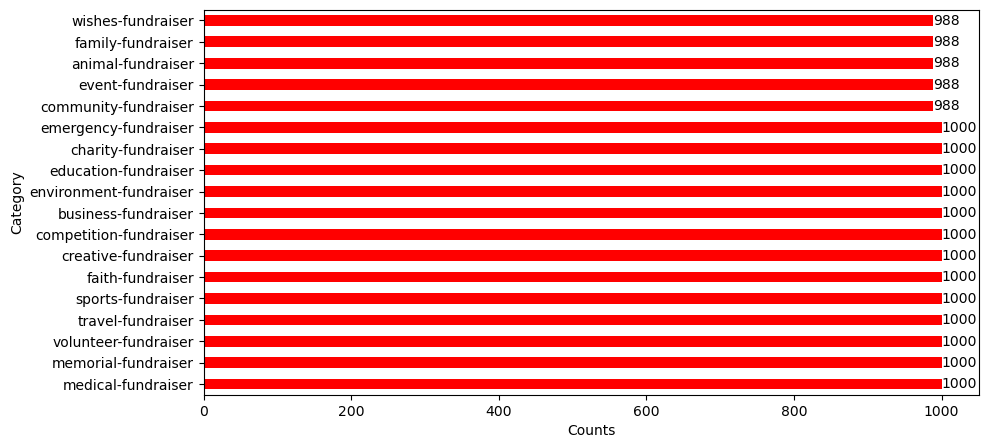

In [14]:
# Distribution of campaign links for each category

plt.figure(figsize= (10,5))
ax1 = all_links_df['category'].value_counts().plot(kind='barh',color='r')
plt.xlabel('Counts')
plt.ylabel('Category')

for container in ax1.containers:
    ax1.bar_label(container)
    
plt.show()

In [15]:
# Since the time taken to extract the information from each campaign link is high, only 50% of campaigns are considered 
# for each of the category without changing the distribution of the campaign links from each category.

all_links_df_reduced,_ = train_test_split(all_links_df, train_size=0.50, 
                         stratify = all_links_df['category'],random_state=32)

In [16]:
all_links_df_reduced.head()

,campaign_link,category
16205,https://www.gofundme.com//f/crystals-birthday-...,volunteer-fundraiser
5124,https://www.gofundme.com//f/get-beryl-to-maine...,animal-fundraiser
16235,https://www.gofundme.com//f/running-for-change...,volunteer-fundraiser
2188,https://www.gofundme.com//f/helpmaryamfamily?q...,emergency-fundraiser
1612,https://www.gofundme.com//f/support-for-robert...,memorial-fundraiser


In [17]:
all_links_df_reduced.shape

(8970, 2)

The effective number of campagin links after desizing the all_links data is 8982. So we now get the information 
from only these 8982
links.

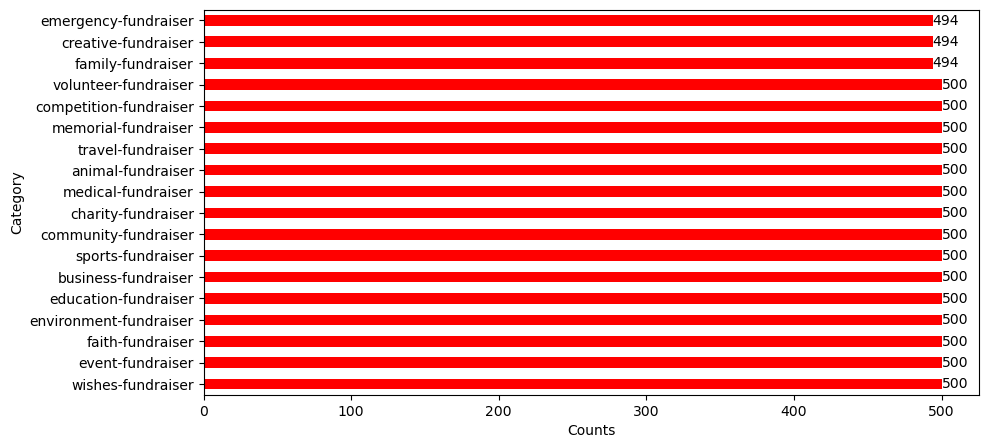

In [17]:
# Distribution of campaign links after desizing the dataset.
plt.figure(figsize= (10,5))

ax2 = all_links_df_reduced['category'].value_counts().plot(kind='barh',color='r')
plt.xlabel('Counts')
plt.ylabel('Category')
for container in ax2.containers:
    ax2.bar_label(container)
    
plt.show()

In [18]:
async def campaign_info(page,links_df):
    """Get campaign info after loading the campaign page"""
    
    TITLE = []
    RAISED_AMOUNT = []
    GOAL_AMOUNT   = []
    DATE_SPAN     = []
    STORY = []
    NO_OF_DONATIONS = []
    IMAGE = []
    ORGANIZER  = []
    LOCATION   = []
    CAMPAIGN_lINK = []
    CATEGORY   = []
    
    all_links  = links_df['campaign_link'].tolist()
    all_categories = links_df['category'].tolist()
    
    for i,j in enumerate(tqdm(all_links)):
        
        try:
            await page.goto(j,timeout = 80000)
            await page.wait_for_timeout(2000)
            content = await page.content()
            soup = BeautifulSoup(content, 'html.parser')
            # # Get title
            title = soup.h1.get_text() if soup.h1 else 'N/A'
            
            # Get raised amount
            raised_amount_tag = soup.find('span', class_='hrt-text-body-lg')
            raised_amount = raised_amount_tag.text.strip()[1:] if raised_amount_tag else '0'  # Handle missing cases with '0'
            
            # Get goal amount
            goal_amount = re.search(r'"goalAmount":\{"__typename":"Money","currencyCode":"\w+","amount":(\d+)\}', str(soup)).group(1)
                
            # Get date span
            date_span_tag = soup.find('span', class_='m-campaign-byline-created a-created-date')
            date_span = date_span_tag.text if date_span_tag else 'N/A'
            
            # Get story
            story_section = soup.find('div', class_='campaign-description_content__C1C_5')
            story_text = story_section.get_text(strip=True) if story_section else 'No story provided'
            
            # Get number of donations
            match = re.search(r'(\d+\.?\d*[KM]?) donations', str(soup))
            donations_number = match.group(1) if match else '0'  # Default to '0' if no donations
            
            # Get image link
            image_link = soup.find('link', rel='preload')
            image_url = image_link.get('href') if image_link else 'No image'
            
            # Get Organizer details
            organizer = soup.find('div', class_='hrt-font-bold').get_text()
            
            # Get Location details
            if len(soup.find_all('div', class_='hrt-text-body-sm')[-1].get_text().split(','))==2:
                location  = soup.find_all('div', class_='hrt-text-body-sm')[-1].get_text()
            elif len(soup.find_all('div', class_='hrt-text-body-sm')[-2].get_text().split(','))==2:
                if 'goal' in soup.find_all('div', class_='hrt-text-body-sm')[-2].get_text():
                    location = ''
                else:
                    location  = soup.find_all('div', class_='hrt-text-body-sm')[-2].get_text()
            else:
                location = ''
            
                    
            TITLE.append(title)
            RAISED_AMOUNT.append(raised_amount)
            GOAL_AMOUNT.append(goal_amount)
            DATE_SPAN.append(date_span)
            STORY.append(story_text)
            NO_OF_DONATIONS.append(donations_number)
            IMAGE.append(image_url)
            ORGANIZER.append(organizer)
            LOCATION.append(location)
            CAMPAIGN_lINK.append(j)
            CATEGORY.append(all_categories[i])

        except Exception as e:
            print(f"Error fetching campaign info: {e}")
            continue
                
    return  TITLE, RAISED_AMOUNT, GOAL_AMOUNT, DATE_SPAN, STORY, NO_OF_DONATIONS, IMAGE, ORGANIZER, LOCATION, CAMPAIGN_lINK, CATEGORY         

In [19]:
async with async_playwright() as p:
    browser = await p.chromium.launch()
    page = await browser.new_page()
    TITLE, RAISED_AMOUNT, GOAL_AMOUNT, DATE_SPAN, STORY, NO_OF_DONATIONS, IMAGE, ORGANIZER, LOCATION, CAMPAIGN_lINK, CATEGORY = await campaign_info(page,all_links_df_reduced)
    await browser.close()

  1%|▍                                      | 97/8970 [05:07<7:11:51,  2.92s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                      | 98/8970 [05:09<6:35:04,  2.67s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                      | 99/8970 [05:11<6:09:09,  2.50s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 100/8970 [05:14<5:54:48,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 101/8970 [05:16<5:41:35,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 102/8970 [05:18<5:32:35,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 103/8970 [05:20<5:25:02,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 104/8970 [05:22<5:19:53,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 105/8970 [05:24<5:16:06,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 106/8970 [05:26<5:18:16,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 107/8970 [05:28<5:15:20,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 108/8970 [05:30<5:13:16,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 109/8970 [05:32<5:12:04,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 110/8970 [05:35<5:11:17,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 111/8970 [05:37<5:10:31,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 112/8970 [05:39<5:09:55,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 113/8970 [05:41<5:09:17,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 114/8970 [05:43<5:08:42,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  1%|▍                                     | 115/8970 [05:45<5:08:37,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  2%|▉                                     | 219/8970 [11:18<6:55:05,  2.85s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  2%|▉                                     | 220/8970 [11:20<6:21:27,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  2%|▉                                     | 221/8970 [11:22<5:58:29,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  2%|▉                                     | 222/8970 [11:24<5:42:20,  2.35s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  2%|▉                                     | 223/8970 [11:26<5:31:20,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  2%|▉                                     | 224/8970 [11:28<5:23:14,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 225/8970 [11:31<5:17:49,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 226/8970 [11:33<5:13:42,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 227/8970 [11:35<5:10:39,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 228/8970 [11:37<5:09:30,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 229/8970 [11:39<5:08:41,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 230/8970 [11:41<5:08:21,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 231/8970 [11:43<5:06:48,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  3%|▉                                     | 232/8970 [11:45<5:07:20,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 333/8970 [17:08<6:56:02,  2.89s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 334/8970 [17:10<6:21:22,  2.65s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 335/8970 [17:13<5:57:03,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 336/8970 [17:15<5:40:17,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 337/8970 [17:17<5:28:14,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 338/8970 [17:19<5:19:56,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 339/8970 [17:21<5:13:56,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 340/8970 [17:23<5:09:57,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 341/8970 [17:25<5:07:27,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 342/8970 [17:27<5:05:35,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 343/8970 [17:29<5:04:23,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 344/8970 [17:31<5:03:22,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 345/8970 [17:33<5:02:21,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 346/8970 [17:36<5:01:46,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 347/8970 [17:38<5:01:22,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 348/8970 [17:40<5:01:16,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 349/8970 [17:42<5:00:52,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 350/8970 [17:44<5:00:31,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  4%|█▍                                    | 351/8970 [17:46<5:00:06,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 452/8970 [23:10<6:51:12,  2.90s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 453/8970 [23:12<6:16:33,  2.65s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 454/8970 [23:14<5:51:57,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 455/8970 [23:16<5:35:29,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 456/8970 [23:18<5:23:19,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 457/8970 [23:20<5:15:18,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 458/8970 [23:22<5:09:26,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 459/8970 [23:24<5:05:31,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 460/8970 [23:27<5:02:29,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 461/8970 [23:29<5:00:15,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 462/8970 [23:31<4:58:58,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 463/8970 [23:33<4:57:23,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 464/8970 [23:35<4:56:47,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 465/8970 [23:37<4:56:45,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 466/8970 [23:39<4:56:35,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 467/8970 [23:41<4:56:26,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 468/8970 [23:43<4:56:05,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  5%|█▉                                    | 469/8970 [23:45<4:56:40,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 576/8970 [29:28<6:41:11,  2.87s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 577/8970 [29:30<6:08:11,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 578/8970 [29:32<5:45:19,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 579/8970 [29:34<5:29:21,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 580/8970 [29:36<5:18:26,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 581/8970 [29:38<5:10:48,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 582/8970 [29:40<5:05:25,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  6%|██▍                                   | 583/8970 [29:42<5:01:19,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  7%|██▍                                   | 584/8970 [29:44<4:58:48,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  7%|██▍                                   | 585/8970 [29:46<4:56:52,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 689/8970 [35:19<6:34:14,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 690/8970 [35:21<6:02:15,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 691/8970 [35:23<5:39:49,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 692/8970 [35:25<5:24:32,  2.35s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 693/8970 [35:27<5:13:39,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 694/8970 [35:30<5:06:04,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 695/8970 [35:32<5:01:02,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 696/8970 [35:34<4:58:18,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 697/8970 [35:36<4:55:35,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 698/8970 [35:38<4:53:42,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 699/8970 [35:40<4:51:49,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 700/8970 [35:42<4:50:40,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 701/8970 [35:44<4:49:52,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  8%|██▉                                   | 702/8970 [35:46<4:49:10,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 830/8970 [42:39<6:22:16,  2.82s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 831/8970 [42:41<5:52:34,  2.60s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 832/8970 [42:43<5:31:34,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 833/8970 [42:46<5:24:08,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 834/8970 [42:48<5:11:47,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 835/8970 [42:50<5:03:50,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 836/8970 [42:52<4:57:50,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 837/8970 [42:54<4:54:05,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


  9%|███▌                                  | 838/8970 [42:56<4:51:48,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 932/8970 [47:58<6:27:42,  2.89s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 933/8970 [48:00<5:55:36,  2.65s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 934/8970 [48:02<5:32:48,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 935/8970 [48:04<5:17:01,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 936/8970 [48:07<5:06:06,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 937/8970 [48:09<4:57:30,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 938/8970 [48:11<4:52:18,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 939/8970 [48:13<4:48:31,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 940/8970 [48:15<4:45:24,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 10%|███▉                                  | 941/8970 [48:17<4:43:34,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 11%|███▉                                  | 942/8970 [48:19<4:41:54,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 11%|███▉                                  | 943/8970 [48:21<4:41:11,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 11%|███▉                                  | 944/8970 [48:23<4:40:45,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 11%|████                                  | 945/8970 [48:25<4:39:55,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 11%|████▏                                | 1013/8970 [52:03<6:43:49,  3.05s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1037/8970 [53:20<6:28:10,  2.94s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1038/8970 [53:22<5:54:21,  2.68s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1039/8970 [53:24<5:30:34,  2.50s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1040/8970 [53:26<5:14:14,  2.38s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1041/8970 [53:28<5:02:34,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1042/8970 [53:30<4:54:29,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1043/8970 [53:32<4:49:02,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1044/8970 [53:35<4:45:37,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1045/8970 [53:37<4:42:39,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1046/8970 [53:39<4:40:22,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1047/8970 [53:41<4:39:01,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1048/8970 [53:43<4:37:37,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 12%|████▎                                | 1049/8970 [53:45<4:37:04,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1154/8970 [59:18<6:21:29,  2.93s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1155/8970 [59:20<5:54:48,  2.72s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1156/8970 [59:22<5:29:39,  2.53s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1157/8970 [59:24<5:12:15,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1158/8970 [59:27<4:59:55,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1159/8970 [59:29<4:51:12,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1160/8970 [59:31<4:45:25,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1161/8970 [59:33<4:41:26,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1162/8970 [59:35<4:38:41,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1163/8970 [59:37<4:36:44,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1164/8970 [59:39<4:35:19,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1165/8970 [59:41<4:33:52,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1166/8970 [59:43<4:33:01,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 13%|████▊                                | 1167/8970 [59:45<4:32:15,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|████▉                              | 1280/8970 [1:05:47<6:03:15,  2.83s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|████▉                              | 1281/8970 [1:05:49<5:34:29,  2.61s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1282/8970 [1:05:51<5:14:26,  2.45s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1283/8970 [1:05:53<5:00:26,  2.35s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1284/8970 [1:05:55<4:50:26,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1285/8970 [1:05:58<4:43:38,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1286/8970 [1:06:00<4:38:48,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1287/8970 [1:06:02<4:35:41,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1288/8970 [1:06:04<4:33:02,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 14%|█████                              | 1289/8970 [1:06:06<4:31:20,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1381/8970 [1:11:00<6:07:55,  2.91s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1382/8970 [1:11:02<5:37:06,  2.67s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1383/8970 [1:11:04<5:15:06,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1384/8970 [1:11:06<4:59:35,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1385/8970 [1:11:08<4:48:39,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1386/8970 [1:11:10<4:40:43,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1387/8970 [1:11:12<4:35:36,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1388/8970 [1:11:15<4:31:58,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1389/8970 [1:11:17<4:29:48,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 15%|█████▍                             | 1390/8970 [1:11:19<4:27:57,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1391/8970 [1:11:21<4:26:28,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1392/8970 [1:11:23<4:25:31,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1393/8970 [1:11:25<4:24:31,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1394/8970 [1:11:27<4:24:01,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1395/8970 [1:11:29<4:24:03,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1396/8970 [1:11:31<4:23:57,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1397/8970 [1:11:33<4:23:56,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 16%|█████▍                             | 1398/8970 [1:11:35<4:23:38,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1493/8970 [1:16:38<5:50:12,  2.81s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1494/8970 [1:16:41<5:23:09,  2.59s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1495/8970 [1:16:43<5:10:48,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1496/8970 [1:16:45<4:55:12,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1497/8970 [1:16:47<4:44:45,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1498/8970 [1:16:49<4:37:14,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1499/8970 [1:16:51<4:32:54,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1500/8970 [1:16:53<4:28:24,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1501/8970 [1:16:55<4:26:14,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1502/8970 [1:16:57<4:24:21,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1503/8970 [1:17:00<4:22:59,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1504/8970 [1:17:02<4:22:07,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▊                             | 1505/8970 [1:17:04<4:21:01,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 17%|█████▉                             | 1506/8970 [1:17:06<4:20:30,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 18%|██████▎                            | 1631/8970 [1:23:47<5:45:09,  2.82s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 18%|██████▎                            | 1632/8970 [1:23:50<5:18:02,  2.60s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 18%|██████▎                            | 1633/8970 [1:23:52<4:59:20,  2.45s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 18%|██████▍                            | 1634/8970 [1:23:54<4:46:00,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 18%|██████▍                            | 1635/8970 [1:23:56<4:36:57,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▌                            | 1688/8970 [1:26:48<5:47:04,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▌                            | 1689/8970 [1:26:50<5:19:02,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▌                            | 1690/8970 [1:26:52<4:59:08,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▌                            | 1691/8970 [1:26:54<4:51:40,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▌                            | 1692/8970 [1:26:56<4:39:55,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▋                            | 1712/8970 [1:28:00<6:22:29,  3.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▋                            | 1713/8970 [1:28:02<5:49:36,  2.89s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▋                            | 1714/8970 [1:28:04<5:20:15,  2.65s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▋                            | 1715/8970 [1:28:06<4:59:47,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1741/8970 [1:29:28<5:34:13,  2.77s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1742/8970 [1:29:30<5:09:27,  2.57s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1743/8970 [1:29:32<4:51:26,  2.42s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1744/8970 [1:29:34<4:39:21,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1745/8970 [1:29:36<4:30:42,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1746/8970 [1:29:38<4:24:28,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1747/8970 [1:29:40<4:20:35,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1748/8970 [1:29:42<4:17:18,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 19%|██████▊                            | 1749/8970 [1:29:44<4:15:12,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 20%|██████▊                            | 1750/8970 [1:29:46<4:13:48,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▏                           | 1857/8970 [1:35:27<5:39:02,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▏                           | 1858/8970 [1:35:29<5:11:49,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1859/8970 [1:35:31<4:52:16,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1860/8970 [1:35:33<4:44:51,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1861/8970 [1:35:36<4:33:32,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1862/8970 [1:35:38<4:28:03,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1863/8970 [1:35:40<4:21:55,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1864/8970 [1:35:42<4:17:41,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1865/8970 [1:35:44<4:14:50,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1866/8970 [1:35:46<4:12:37,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1867/8970 [1:35:48<4:10:58,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1868/8970 [1:35:50<4:09:55,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1869/8970 [1:35:52<4:09:11,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1870/8970 [1:35:54<4:08:22,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 21%|███████▎                           | 1871/8970 [1:35:57<4:07:40,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1973/8970 [1:41:27<5:28:47,  2.82s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1974/8970 [1:41:29<5:02:59,  2.60s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1975/8970 [1:41:31<4:44:54,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1976/8970 [1:41:33<4:32:32,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1977/8970 [1:41:36<4:23:38,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1978/8970 [1:41:38<4:17:28,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1979/8970 [1:41:40<4:13:20,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1980/8970 [1:41:42<4:10:15,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1981/8970 [1:41:44<4:08:09,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1982/8970 [1:41:46<4:06:36,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1983/8970 [1:41:48<4:05:34,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1984/8970 [1:41:50<4:04:28,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1985/8970 [1:41:52<4:04:20,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▋                           | 1986/8970 [1:41:54<4:03:41,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 22%|███████▊                           | 1987/8970 [1:41:56<4:03:17,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 24%|████████▏                          | 2111/8970 [1:48:38<5:22:09,  2.82s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 24%|████████▏                          | 2112/8970 [1:48:40<4:56:55,  2.60s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 24%|████████▏                          | 2113/8970 [1:48:42<4:39:18,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 24%|████████▏                          | 2114/8970 [1:48:45<4:26:44,  2.33s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 24%|████████▎                          | 2115/8970 [1:48:47<4:17:55,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2213/8970 [1:53:59<5:15:50,  2.80s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2214/8970 [1:54:01<4:51:22,  2.59s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2215/8970 [1:54:03<4:34:45,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2216/8970 [1:54:05<4:22:19,  2.33s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2217/8970 [1:54:07<4:14:03,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2218/8970 [1:54:09<4:10:56,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2219/8970 [1:54:11<4:05:51,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2220/8970 [1:54:13<4:02:12,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2221/8970 [1:54:15<3:59:53,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2222/8970 [1:54:18<3:58:48,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2223/8970 [1:54:20<3:57:32,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2224/8970 [1:54:22<3:56:44,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2225/8970 [1:54:24<3:55:51,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 25%|████████▋                          | 2226/8970 [1:54:26<3:55:22,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2340/8970 [2:00:37<5:13:35,  2.84s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2341/8970 [2:00:40<4:54:13,  2.66s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2342/8970 [2:00:42<4:35:11,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2343/8970 [2:00:44<4:21:58,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2344/8970 [2:00:46<4:12:23,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2345/8970 [2:00:48<4:05:44,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2346/8970 [2:00:50<4:01:16,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2347/8970 [2:00:52<3:57:37,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2348/8970 [2:00:54<3:55:37,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 26%|█████████▏                         | 2349/8970 [2:00:56<3:54:10,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2450/8970 [2:06:20<5:19:20,  2.94s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2451/8970 [2:06:22<4:56:36,  2.73s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2452/8970 [2:06:24<4:35:41,  2.54s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2453/8970 [2:06:26<4:21:03,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2454/8970 [2:06:28<4:10:51,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2455/8970 [2:06:30<4:03:25,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2456/8970 [2:06:32<3:58:28,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2457/8970 [2:06:34<3:54:48,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2458/8970 [2:06:36<3:52:18,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2459/8970 [2:06:39<3:50:36,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2460/8970 [2:06:41<3:49:20,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2461/8970 [2:06:43<3:48:31,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2462/8970 [2:06:45<3:47:58,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 27%|█████████▌                         | 2463/8970 [2:06:47<3:47:23,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2566/8970 [2:12:20<4:59:59,  2.81s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2567/8970 [2:12:22<4:36:39,  2.59s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2568/8970 [2:12:24<4:20:28,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2569/8970 [2:12:26<4:09:02,  2.33s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2570/8970 [2:12:28<4:00:50,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2571/8970 [2:12:30<4:00:36,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2572/8970 [2:12:33<3:55:15,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2573/8970 [2:12:35<3:51:18,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2574/8970 [2:12:37<3:48:40,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2575/8970 [2:12:39<3:46:24,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2576/8970 [2:12:41<3:45:16,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2577/8970 [2:12:43<3:44:26,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 29%|██████████                         | 2578/8970 [2:12:45<3:43:56,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2679/8970 [2:18:07<4:56:16,  2.83s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2680/8970 [2:18:09<4:32:54,  2.60s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2681/8970 [2:18:11<4:16:20,  2.45s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2682/8970 [2:18:13<4:05:09,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2683/8970 [2:18:16<3:56:59,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2684/8970 [2:18:18<3:51:11,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2685/8970 [2:18:20<3:47:46,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2686/8970 [2:18:22<3:45:04,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2687/8970 [2:18:24<3:43:01,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2688/8970 [2:18:26<3:41:34,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2689/8970 [2:18:28<3:40:23,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▍                        | 2690/8970 [2:18:30<3:39:43,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▌                        | 2691/8970 [2:18:32<3:39:33,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▌                        | 2692/8970 [2:18:34<3:39:23,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 30%|██████████▌                        | 2693/8970 [2:18:36<3:39:01,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2875/8970 [2:29:28<4:44:08,  2.80s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2876/8970 [2:29:30<4:27:24,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2877/8970 [2:29:33<4:10:42,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2878/8970 [2:29:35<3:59:08,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2879/8970 [2:29:37<3:50:46,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2880/8970 [2:29:39<3:45:06,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2881/8970 [2:29:41<3:41:14,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2882/8970 [2:29:43<3:43:45,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 32%|███████████▏                       | 2883/8970 [2:29:45<3:40:12,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2990/8970 [2:35:29<4:45:39,  2.87s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2991/8970 [2:35:31<4:22:08,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2992/8970 [2:35:33<4:05:51,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2993/8970 [2:35:35<3:59:42,  2.41s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2994/8970 [2:35:37<3:49:33,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2995/8970 [2:35:39<3:42:40,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2996/8970 [2:35:42<3:38:07,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2997/8970 [2:35:44<3:34:56,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 33%|███████████▋                       | 2998/8970 [2:35:46<3:32:56,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 34%|████████████                       | 3078/8970 [2:39:59<4:53:27,  2.99s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 34%|████████████                       | 3079/8970 [2:40:01<4:26:48,  2.72s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 34%|████████████                       | 3080/8970 [2:40:03<4:08:03,  2.53s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 34%|████████████                       | 3081/8970 [2:40:05<3:54:53,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3095/8970 [2:40:50<4:44:30,  2.91s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3096/8970 [2:40:52<4:25:15,  2.71s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3097/8970 [2:40:54<4:07:07,  2.52s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3098/8970 [2:40:56<3:54:21,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3099/8970 [2:40:58<3:45:23,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3100/8970 [2:41:00<3:39:13,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3101/8970 [2:41:02<3:34:37,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3102/8970 [2:41:04<3:31:08,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 35%|████████████                       | 3103/8970 [2:41:06<3:29:07,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3209/8970 [2:46:48<4:33:43,  2.85s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3210/8970 [2:46:50<4:11:34,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3211/8970 [2:46:53<4:01:07,  2.51s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3212/8970 [2:46:55<3:48:28,  2.38s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3213/8970 [2:46:57<3:39:59,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3214/8970 [2:46:59<3:34:25,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3215/8970 [2:47:01<3:35:59,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3216/8970 [2:47:03<3:31:17,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 36%|████████████▌                      | 3217/8970 [2:47:05<3:27:51,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3309/8970 [2:51:59<4:31:47,  2.88s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3310/8970 [2:52:01<4:14:04,  2.69s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3311/8970 [2:52:04<3:56:47,  2.51s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3312/8970 [2:52:06<3:48:44,  2.43s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3313/8970 [2:52:08<3:38:57,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3314/8970 [2:52:10<3:32:27,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3315/8970 [2:52:12<3:27:42,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3316/8970 [2:52:14<3:24:10,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3317/8970 [2:52:16<3:21:42,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3318/8970 [2:52:18<3:19:57,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3319/8970 [2:52:20<3:18:46,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3320/8970 [2:52:22<3:18:04,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3321/8970 [2:52:25<3:17:31,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 37%|████████████▉                      | 3322/8970 [2:52:27<3:17:07,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3443/8970 [2:58:59<4:17:55,  2.80s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3444/8970 [2:59:01<4:00:04,  2.61s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3445/8970 [2:59:03<3:46:01,  2.45s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3446/8970 [2:59:05<3:35:53,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3447/8970 [2:59:08<3:30:40,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3448/8970 [2:59:10<3:25:21,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3449/8970 [2:59:12<3:23:00,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3450/8970 [2:59:14<3:19:46,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3451/8970 [2:59:16<3:18:56,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3452/8970 [2:59:18<3:16:47,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 38%|█████████████▍                     | 3453/8970 [2:59:20<3:15:35,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▍                     | 3454/8970 [2:59:22<3:16:07,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▍                     | 3455/8970 [2:59:24<3:14:45,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▍                     | 3456/8970 [2:59:27<3:15:21,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▊                     | 3538/8970 [3:03:47<4:21:00,  2.88s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▊                     | 3539/8970 [3:03:49<3:59:15,  2.64s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▊                     | 3540/8970 [3:03:51<3:45:47,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▊                     | 3541/8970 [3:03:53<3:34:31,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▊                     | 3542/8970 [3:03:55<3:27:20,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 39%|█████████████▊                     | 3543/8970 [3:03:58<3:43:56,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3544/8970 [3:04:00<3:33:26,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3545/8970 [3:04:03<3:34:34,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3546/8970 [3:04:05<3:26:44,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3547/8970 [3:04:07<3:23:16,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3548/8970 [3:04:09<3:18:47,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3549/8970 [3:04:11<3:17:34,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3550/8970 [3:04:13<3:14:50,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 40%|█████████████▊                     | 3551/8970 [3:04:16<3:12:49,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3653/8970 [3:09:49<4:08:32,  2.80s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3654/8970 [3:09:51<3:51:07,  2.61s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3655/8970 [3:09:53<3:37:32,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3656/8970 [3:09:55<3:27:28,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3657/8970 [3:09:57<3:22:02,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3658/8970 [3:10:00<3:17:04,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3659/8970 [3:10:02<3:15:12,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3660/8970 [3:10:04<3:11:58,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3661/8970 [3:10:06<3:09:57,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3662/8970 [3:10:08<3:09:54,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3663/8970 [3:10:10<3:08:21,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3664/8970 [3:10:12<3:08:30,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3665/8970 [3:10:14<3:07:19,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 41%|██████████████▎                    | 3666/8970 [3:10:17<3:07:48,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 42%|██████████████▋                    | 3768/8970 [3:15:48<4:12:45,  2.92s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 42%|██████████████▋                    | 3769/8970 [3:15:50<3:51:16,  2.67s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 42%|██████████████▋                    | 3770/8970 [3:15:52<3:38:11,  2.52s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 42%|██████████████▋                    | 3771/8970 [3:15:54<3:27:09,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 42%|██████████████▋                    | 3772/8970 [3:15:56<3:21:21,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3884/8970 [3:22:00<4:03:55,  2.88s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3885/8970 [3:22:02<3:45:28,  2.66s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3886/8970 [3:22:04<3:31:02,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3887/8970 [3:22:06<3:22:24,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3888/8970 [3:22:09<3:14:47,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3889/8970 [3:22:11<3:14:07,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3890/8970 [3:22:13<3:11:43,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3891/8970 [3:22:15<3:07:26,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3892/8970 [3:22:17<3:05:53,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3893/8970 [3:22:19<3:03:03,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3894/8970 [3:22:21<3:02:39,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3895/8970 [3:22:24<3:00:40,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 43%|███████████████▏                   | 3896/8970 [3:22:26<2:59:30,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▌                   | 4000/8970 [3:28:00<4:03:41,  2.94s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▌                   | 4001/8970 [3:28:02<3:43:59,  2.70s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▌                   | 4002/8970 [3:28:04<3:28:50,  2.52s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▌                   | 4003/8970 [3:28:06<3:19:34,  2.41s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▌                   | 4004/8970 [3:28:08<3:11:32,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4005/8970 [3:28:10<3:06:01,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4006/8970 [3:28:12<3:03:48,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4007/8970 [3:28:14<3:00:34,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4008/8970 [3:28:17<2:59:51,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4009/8970 [3:28:19<2:57:37,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4010/8970 [3:28:21<2:56:10,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4011/8970 [3:28:23<2:56:50,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 45%|███████████████▋                   | 4012/8970 [3:28:25<2:55:12,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4114/8970 [3:33:49<3:43:08,  2.76s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4115/8970 [3:33:51<3:28:28,  2.58s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4116/8970 [3:33:53<3:16:25,  2.43s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4117/8970 [3:33:55<3:09:32,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4118/8970 [3:33:58<3:05:02,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4119/8970 [3:34:00<3:00:21,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4120/8970 [3:34:02<2:58:32,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4121/8970 [3:34:04<2:55:51,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4122/8970 [3:34:06<2:53:48,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4123/8970 [3:34:08<2:53:48,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4124/8970 [3:34:10<2:52:17,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4125/8970 [3:34:13<2:55:19,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4126/8970 [3:34:15<2:53:35,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 46%|████████████████                   | 4127/8970 [3:34:17<2:53:52,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▍                  | 4227/8970 [3:39:40<3:41:46,  2.81s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▍                  | 4228/8970 [3:39:42<3:26:14,  2.61s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4229/8970 [3:39:44<3:14:04,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4230/8970 [3:39:46<3:06:49,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4231/8970 [3:39:48<3:00:21,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4232/8970 [3:39:51<2:55:53,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4233/8970 [3:39:53<2:54:02,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4234/8970 [3:39:55<2:51:13,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4235/8970 [3:39:57<2:50:48,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4236/8970 [3:39:59<2:49:03,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4237/8970 [3:40:01<2:47:55,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4238/8970 [3:40:03<2:48:32,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 47%|████████████████▌                  | 4239/8970 [3:40:05<2:47:40,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4338/8970 [3:45:20<3:39:36,  2.84s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4339/8970 [3:45:22<3:23:30,  2.64s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4340/8970 [3:45:24<3:10:59,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4341/8970 [3:45:26<3:01:57,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4342/8970 [3:45:28<2:57:33,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4343/8970 [3:45:30<2:52:41,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4344/8970 [3:45:32<2:50:51,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4345/8970 [3:45:35<2:47:46,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4346/8970 [3:45:37<2:46:59,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4347/8970 [3:45:39<2:45:02,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4348/8970 [3:45:41<2:43:48,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4349/8970 [3:45:43<2:44:26,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 48%|████████████████▉                  | 4350/8970 [3:45:45<2:43:25,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 49%|████████████████▉                  | 4351/8970 [3:45:47<2:44:02,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 49%|████████████████▉                  | 4352/8970 [3:45:49<2:43:00,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 49%|████████████████▉                  | 4353/8970 [3:45:52<2:43:48,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 49%|████████████████▉                  | 4354/8970 [3:45:54<2:42:52,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 49%|████████████████▉                  | 4355/8970 [3:45:56<2:42:27,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4456/8970 [3:51:29<3:48:26,  3.04s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4457/8970 [3:51:31<3:27:04,  2.75s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4458/8970 [3:51:33<3:17:15,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4459/8970 [3:51:35<3:05:08,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4460/8970 [3:51:38<2:58:04,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4461/8970 [3:51:40<2:51:44,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4462/8970 [3:51:42<2:48:25,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4463/8970 [3:51:44<2:44:45,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4464/8970 [3:51:46<2:42:14,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4465/8970 [3:51:48<2:42:05,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4466/8970 [3:51:50<2:40:14,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4467/8970 [3:51:52<2:40:47,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4468/8970 [3:51:55<2:39:23,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 50%|█████████████████▍                 | 4469/8970 [3:51:57<2:39:48,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4567/8970 [3:57:10<3:37:15,  2.96s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4568/8970 [3:57:12<3:20:01,  2.73s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4569/8970 [3:57:14<3:06:02,  2.54s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4570/8970 [3:57:16<2:57:21,  2.42s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4571/8970 [3:57:18<2:50:15,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4572/8970 [3:57:20<2:45:17,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4573/8970 [3:57:22<2:42:39,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4574/8970 [3:57:25<2:39:50,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4575/8970 [3:57:27<2:39:14,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4576/8970 [3:57:29<2:37:35,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4577/8970 [3:57:31<2:37:25,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4578/8970 [3:57:33<2:36:06,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 51%|█████████████████▊                 | 4579/8970 [3:57:35<2:35:13,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4685/8970 [4:03:17<3:23:54,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4686/8970 [4:03:20<3:07:19,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4687/8970 [4:03:22<2:57:47,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4688/8970 [4:03:24<2:49:05,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4689/8970 [4:03:26<2:44:07,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4690/8970 [4:03:28<2:39:30,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4691/8970 [4:03:30<2:36:29,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4692/8970 [4:03:32<2:35:33,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4693/8970 [4:03:34<2:33:20,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4694/8970 [4:03:36<2:33:26,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4695/8970 [4:03:39<2:31:58,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4696/8970 [4:03:41<2:31:06,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4697/8970 [4:03:43<2:31:29,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 52%|██████████████████▎                | 4698/8970 [4:03:45<2:30:42,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 54%|██████████████████▉                | 4855/8970 [4:12:11<3:39:36,  3.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 54%|██████████████████▉                | 4856/8970 [4:12:15<3:51:12,  3.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 54%|██████████████████▉                | 4857/8970 [4:12:17<3:26:11,  3.01s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4945/8970 [4:17:00<3:11:40,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4946/8970 [4:17:02<2:57:43,  2.65s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4947/8970 [4:17:04<2:46:35,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4948/8970 [4:17:06<2:38:40,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4949/8970 [4:17:08<2:34:31,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4950/8970 [4:17:10<2:30:09,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4951/8970 [4:17:12<2:28:17,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4952/8970 [4:17:14<2:25:43,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4953/8970 [4:17:17<2:25:26,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4954/8970 [4:17:19<2:23:50,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4955/8970 [4:17:21<2:22:43,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4956/8970 [4:17:23<2:23:11,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 55%|███████████████████▎               | 4957/8970 [4:17:25<2:22:08,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 57%|████████████████████               | 5127/8970 [4:26:37<3:04:20,  2.88s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 57%|████████████████████               | 5128/8970 [4:26:39<2:49:14,  2.64s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 57%|████████████████████               | 5129/8970 [4:26:41<2:39:53,  2.50s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 57%|████████████████████               | 5130/8970 [4:26:43<2:32:08,  2.38s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 57%|████████████████████               | 5131/8970 [4:26:45<2:26:38,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▏              | 5188/8970 [4:29:47<3:03:20,  2.91s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▏              | 5189/8970 [4:29:49<2:47:55,  2.66s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5190/8970 [4:29:51<2:38:01,  2.51s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5191/8970 [4:29:53<2:30:09,  2.38s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5192/8970 [4:29:55<2:24:26,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5193/8970 [4:29:58<2:22:34,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5194/8970 [4:30:00<2:19:37,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5195/8970 [4:30:02<2:18:23,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5196/8970 [4:30:04<2:16:15,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 58%|████████████████████▎              | 5197/8970 [4:30:06<2:16:03,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5329/8970 [4:37:17<2:52:26,  2.84s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5330/8970 [4:37:19<2:38:43,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5331/8970 [4:37:21<2:30:11,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5332/8970 [4:37:23<2:22:56,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5333/8970 [4:37:26<2:18:15,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5334/8970 [4:37:28<2:16:09,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5335/8970 [4:37:30<2:13:22,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5336/8970 [4:37:32<2:12:38,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 59%|████████████████████▊              | 5337/8970 [4:37:34<2:10:51,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 60%|████████████████████▊              | 5338/8970 [4:37:36<2:11:01,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▏             | 5441/8970 [4:43:10<2:49:23,  2.88s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▏             | 5442/8970 [4:43:12<2:36:43,  2.67s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▏             | 5443/8970 [4:43:14<2:26:28,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▏             | 5444/8970 [4:43:17<2:20:26,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▏             | 5445/8970 [4:43:19<2:15:12,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▏             | 5446/8970 [4:43:21<2:11:42,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▎             | 5447/8970 [4:43:23<2:10:21,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▎             | 5448/8970 [4:43:25<2:08:09,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▎             | 5449/8970 [4:43:27<2:07:44,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▎             | 5450/8970 [4:43:29<2:06:08,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▎             | 5451/8970 [4:43:31<2:06:53,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▎             | 5452/8970 [4:43:34<2:05:34,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 61%|█████████████████████▎             | 5453/8970 [4:43:36<2:04:44,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5565/8970 [4:49:37<2:38:07,  2.79s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5566/8970 [4:49:39<2:26:11,  2.58s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5567/8970 [4:49:41<2:18:52,  2.45s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5568/8970 [4:49:44<2:12:46,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5569/8970 [4:49:46<2:11:27,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5570/8970 [4:49:48<2:08:51,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5571/8970 [4:49:50<2:05:47,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5572/8970 [4:49:52<2:05:32,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5573/8970 [4:49:54<2:03:22,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 62%|█████████████████████▋             | 5574/8970 [4:49:56<2:02:47,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████             | 5667/8970 [4:55:00<2:39:37,  2.90s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████             | 5668/8970 [4:55:02<2:27:33,  2.68s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████             | 5669/8970 [4:55:04<2:17:51,  2.51s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████             | 5670/8970 [4:55:06<2:12:18,  2.41s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5671/8970 [4:55:08<2:07:08,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5672/8970 [4:55:11<2:03:32,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5673/8970 [4:55:13<2:02:04,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5674/8970 [4:55:15<1:59:46,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5675/8970 [4:55:17<1:59:20,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5676/8970 [4:55:19<1:58:00,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5677/8970 [4:55:21<1:57:58,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5678/8970 [4:55:23<1:57:11,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5679/8970 [4:55:25<1:56:40,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5680/8970 [4:55:28<1:57:04,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5681/8970 [4:55:30<1:56:23,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5682/8970 [4:55:32<1:56:45,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5683/8970 [4:55:34<1:56:02,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 63%|██████████████████████▏            | 5684/8970 [4:55:36<1:58:20,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5820/8970 [5:03:10<2:30:06,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5821/8970 [5:03:12<2:19:02,  2.65s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5822/8970 [5:03:14<2:10:11,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5823/8970 [5:03:16<2:05:11,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5824/8970 [5:03:18<2:00:30,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5825/8970 [5:03:20<1:57:18,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5826/8970 [5:03:22<1:55:43,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5827/8970 [5:03:24<1:53:46,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5828/8970 [5:03:27<1:53:25,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5829/8970 [5:03:29<1:52:11,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▋            | 5830/8970 [5:03:31<1:51:28,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▊            | 5831/8970 [5:03:33<1:51:47,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 65%|██████████████████████▊            | 5832/8970 [5:03:35<1:50:53,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████            | 5918/8970 [5:08:13<2:39:58,  3.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5932/8970 [5:08:58<2:26:00,  2.88s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5933/8970 [5:09:00<2:13:53,  2.65s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5934/8970 [5:09:02<2:06:34,  2.50s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5935/8970 [5:09:06<2:19:56,  2.77s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5936/8970 [5:09:10<2:39:16,  3.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5937/8970 [5:09:12<2:24:30,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5938/8970 [5:09:14<2:13:00,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5939/8970 [5:09:16<2:05:41,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5940/8970 [5:09:18<1:59:44,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5941/8970 [5:09:20<1:55:26,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5942/8970 [5:09:23<1:53:21,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5943/8970 [5:09:25<1:51:07,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 66%|███████████████████████▏           | 5944/8970 [5:09:27<1:50:34,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 68%|███████████████████████▋           | 6086/8970 [5:17:09<2:19:45,  2.91s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 68%|███████████████████████▊           | 6087/8970 [5:17:11<2:08:54,  2.68s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 68%|███████████████████████▊           | 6088/8970 [5:17:13<2:00:27,  2.51s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 68%|███████████████████████▊           | 6089/8970 [5:17:15<1:54:24,  2.38s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 68%|███████████████████████▉           | 6140/8970 [5:20:02<2:53:27,  3.68s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 68%|███████████████████████▉           | 6141/8970 [5:20:04<2:30:52,  3.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6167/8970 [5:21:29<2:13:11,  2.85s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6168/8970 [5:21:31<2:04:50,  2.67s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6169/8970 [5:21:33<1:57:45,  2.52s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6170/8970 [5:21:35<1:51:26,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6171/8970 [5:21:38<1:50:45,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6172/8970 [5:21:40<1:46:47,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6173/8970 [5:21:42<1:45:15,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6174/8970 [5:21:44<1:43:04,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 69%|████████████████████████           | 6175/8970 [5:21:46<1:41:21,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6281/8970 [5:27:28<2:14:30,  3.00s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6282/8970 [5:27:30<2:02:22,  2.73s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6283/8970 [5:27:32<1:54:48,  2.56s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6284/8970 [5:27:34<1:48:23,  2.42s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6285/8970 [5:27:36<1:46:56,  2.39s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6286/8970 [5:27:39<1:43:02,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6287/8970 [5:27:41<1:40:11,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6288/8970 [5:27:43<1:39:12,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 70%|████████████████████████▌          | 6289/8970 [5:27:45<1:37:21,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6400/8970 [5:33:58<2:05:32,  2.93s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6401/8970 [5:34:00<1:54:49,  2.68s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6402/8970 [5:34:02<1:48:11,  2.53s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6403/8970 [5:34:04<1:42:35,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6404/8970 [5:34:06<1:39:18,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6405/8970 [5:34:08<1:36:17,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6406/8970 [5:34:11<1:34:15,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|████████████████████████▉          | 6407/8970 [5:34:13<1:33:26,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|█████████████████████████          | 6408/8970 [5:34:15<1:32:17,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 71%|█████████████████████████          | 6409/8970 [5:34:17<1:32:34,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▍         | 6532/8970 [5:41:00<1:59:29,  2.94s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▍         | 6533/8970 [5:41:02<1:49:54,  2.71s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▍         | 6534/8970 [5:41:04<1:42:24,  2.52s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▍         | 6535/8970 [5:41:06<1:37:17,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▌         | 6536/8970 [5:41:08<1:34:19,  2.33s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▌         | 6537/8970 [5:41:10<1:31:26,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▌         | 6538/8970 [5:41:13<1:30:11,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▌         | 6539/8970 [5:41:15<1:28:42,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 73%|█████████████████████████▌         | 6540/8970 [5:41:17<1:28:17,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|█████████████████████████▉         | 6660/8970 [5:47:59<2:01:54,  3.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|█████████████████████████▉         | 6661/8970 [5:48:02<1:50:12,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|█████████████████████████▉         | 6662/8970 [5:48:04<1:41:16,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|█████████████████████████▉         | 6663/8970 [5:48:06<1:35:04,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|██████████████████████████         | 6664/8970 [5:48:08<1:31:13,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|██████████████████████████         | 6665/8970 [5:48:10<1:27:53,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|██████████████████████████         | 6666/8970 [5:48:12<1:26:22,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|██████████████████████████         | 6667/8970 [5:48:14<1:24:33,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 74%|██████████████████████████         | 6668/8970 [5:48:16<1:23:15,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 75%|██████████████████████████▍        | 6768/8970 [5:53:40<1:43:52,  2.83s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 75%|██████████████████████████▍        | 6769/8970 [5:53:42<1:36:17,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 75%|██████████████████████████▍        | 6770/8970 [5:53:44<1:30:22,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 75%|██████████████████████████▍        | 6771/8970 [5:53:46<1:26:19,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 75%|██████████████████████████▍        | 6772/8970 [5:53:48<1:24:03,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 76%|██████████████████████████▍        | 6773/8970 [5:53:50<1:21:47,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 76%|██████████████████████████▍        | 6774/8970 [5:53:53<1:21:25,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 76%|██████████████████████████▍        | 6775/8970 [5:53:55<1:19:46,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 76%|██████████████████████████▍        | 6776/8970 [5:53:57<1:19:28,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 76%|██████████████████████████▍        | 6777/8970 [5:53:59<1:18:39,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 76%|██████████████████████████▍        | 6778/8970 [5:54:02<1:33:48,  2.57s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 76%|██████████████████████████▍        | 6779/8970 [5:54:05<1:28:33,  2.43s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 78%|███████████████████████████▍       | 7038/8970 [6:08:29<1:40:08,  3.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 78%|███████████████████████████▍       | 7039/8970 [6:08:31<1:30:28,  2.81s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 78%|███████████████████████████▍       | 7040/8970 [6:08:33<1:24:02,  2.61s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 78%|███████████████████████████▍       | 7041/8970 [6:08:35<1:19:02,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▌       | 7076/8970 [6:10:29<1:33:23,  2.96s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▌       | 7077/8970 [6:10:31<1:25:04,  2.70s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▌       | 7078/8970 [6:10:33<1:20:09,  2.54s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▌       | 7079/8970 [6:10:35<1:15:52,  2.41s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▋       | 7080/8970 [6:10:37<1:12:46,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▋       | 7081/8970 [6:10:39<1:11:14,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▋       | 7082/8970 [6:10:41<1:09:26,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▋       | 7083/8970 [6:10:43<1:09:02,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 79%|███████████████████████████▋       | 7084/8970 [6:10:46<1:08:01,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7191/8970 [6:16:40<1:28:09,  2.97s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7192/8970 [6:16:42<1:20:30,  2.72s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7193/8970 [6:16:44<1:15:24,  2.55s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7194/8970 [6:16:46<1:11:19,  2.41s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7195/8970 [6:16:48<1:09:03,  2.33s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7196/8970 [6:16:50<1:06:49,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7197/8970 [6:16:52<1:05:11,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7198/8970 [6:16:54<1:04:42,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 80%|████████████████████████████       | 7199/8970 [6:16:56<1:03:45,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7290/8970 [6:21:50<1:19:39,  2.84s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7291/8970 [6:21:52<1:13:23,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7292/8970 [6:21:54<1:09:25,  2.48s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7293/8970 [6:21:56<1:06:06,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7294/8970 [6:21:58<1:04:14,  2.30s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7295/8970 [6:22:00<1:02:29,  2.24s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7296/8970 [6:22:03<1:01:16,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7297/8970 [6:22:05<1:00:57,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7298/8970 [6:22:07<1:00:11,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7299/8970 [6:22:09<1:01:33,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7300/8970 [6:22:11<1:00:29,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|████████████████████████████▍      | 7301/8970 [6:22:13<1:00:19,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|██████████████████████████████       | 7302/8970 [6:22:15<59:40,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|██████████████████████████████       | 7303/8970 [6:22:18<59:12,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|██████████████████████████████▏      | 7304/8970 [6:22:20<59:34,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|██████████████████████████████▏      | 7305/8970 [6:22:22<59:06,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|██████████████████████████████▏      | 7306/8970 [6:22:24<59:21,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 81%|██████████████████████████████▏      | 7307/8970 [6:22:26<58:53,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|█████████████████████████████      | 7452/8970 [6:30:29<1:13:55,  2.92s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|█████████████████████████████      | 7453/8970 [6:30:31<1:07:33,  2.67s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|█████████████████████████████      | 7454/8970 [6:30:33<1:03:42,  2.52s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|█████████████████████████████      | 7455/8970 [6:30:35<1:00:29,  2.40s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7456/8970 [6:30:37<58:09,  2.31s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7457/8970 [6:30:39<56:57,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7458/8970 [6:30:41<55:42,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7459/8970 [6:30:43<55:19,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7460/8970 [6:30:46<54:49,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7461/8970 [6:30:48<54:13,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7462/8970 [6:30:50<54:19,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7463/8970 [6:30:52<53:45,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7464/8970 [6:30:54<53:56,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 83%|██████████████████████████████▊      | 7465/8970 [6:30:56<53:27,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|█████████████████████████████▌     | 7571/8970 [6:36:48<1:10:10,  3.01s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|█████████████████████████████▌     | 7572/8970 [6:36:50<1:04:18,  2.76s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|███████████████████████████████▏     | 7573/8970 [6:36:52<59:33,  2.56s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|███████████████████████████████▏     | 7574/8970 [6:36:54<56:49,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|███████████████████████████████▏     | 7575/8970 [6:36:56<54:22,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|███████████████████████████████▏     | 7576/8970 [6:36:58<53:03,  2.28s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|███████████████████████████████▎     | 7577/8970 [6:37:01<51:44,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|███████████████████████████████▎     | 7578/8970 [6:37:03<50:44,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 84%|███████████████████████████████▎     | 7579/8970 [6:37:05<50:29,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 85%|███████████████████████████████▎     | 7580/8970 [6:37:07<49:49,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|█████████████████████████████▉     | 7675/8970 [6:42:19<1:01:23,  2.84s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7676/8970 [6:42:21<56:31,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7677/8970 [6:42:23<53:09,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7678/8970 [6:42:25<51:02,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7679/8970 [6:42:27<49:15,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7680/8970 [6:42:29<48:20,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7681/8970 [6:42:31<47:17,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7682/8970 [6:42:33<46:56,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7683/8970 [6:42:35<46:19,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7684/8970 [6:42:38<45:53,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7685/8970 [6:42:40<45:59,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7686/8970 [6:42:42<45:39,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7687/8970 [6:42:44<45:51,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 86%|███████████████████████████████▋     | 7688/8970 [6:42:46<45:28,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7809/8970 [6:49:27<56:18,  2.91s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7810/8970 [6:49:29<51:50,  2.68s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7811/8970 [6:49:31<49:22,  2.56s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7812/8970 [6:49:34<47:02,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7813/8970 [6:49:36<45:02,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7814/8970 [6:49:38<43:36,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7815/8970 [6:49:40<42:57,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7816/8970 [6:49:42<42:06,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7817/8970 [6:49:44<41:48,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 87%|████████████████████████████████▏    | 7818/8970 [6:49:46<41:19,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7929/8970 [6:55:48<50:26,  2.91s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7930/8970 [6:55:50<46:10,  2.66s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7931/8970 [6:55:52<43:11,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7932/8970 [6:55:54<41:10,  2.38s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7933/8970 [6:55:56<39:38,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7934/8970 [6:55:58<38:33,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7935/8970 [6:56:00<37:47,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7936/8970 [6:56:03<37:17,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7937/8970 [6:56:05<36:49,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 88%|████████████████████████████████▋    | 7938/8970 [6:56:07<36:30,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 89%|█████████████████████████████████    | 8026/8970 [7:00:49<44:59,  2.86s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 89%|█████████████████████████████████    | 8027/8970 [7:00:51<41:19,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 89%|█████████████████████████████████    | 8028/8970 [7:00:53<38:41,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████    | 8029/8970 [7:00:55<36:55,  2.35s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████    | 8030/8970 [7:00:57<35:35,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8031/8970 [7:00:59<34:44,  2.22s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8032/8970 [7:01:01<34:05,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8033/8970 [7:01:04<33:36,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8034/8970 [7:01:06<33:16,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8035/8970 [7:01:08<33:03,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8036/8970 [7:01:10<32:51,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8037/8970 [7:01:12<32:40,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8038/8970 [7:01:14<32:32,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 90%|█████████████████████████████████▏   | 8039/8970 [7:01:16<32:27,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8128/8970 [7:05:59<39:27,  2.81s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8129/8970 [7:06:01<36:21,  2.59s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8130/8970 [7:06:04<34:10,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8131/8970 [7:06:06<32:39,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8135/8970 [7:06:17<36:39,  2.63s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8136/8970 [7:06:19<34:21,  2.47s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8137/8970 [7:06:21<32:43,  2.36s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8138/8970 [7:06:24<31:48,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8139/8970 [7:06:26<30:54,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8140/8970 [7:06:28<30:15,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8141/8970 [7:06:30<29:49,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8142/8970 [7:06:32<29:29,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8143/8970 [7:06:34<29:14,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 91%|█████████████████████████████████▌   | 8144/8970 [7:06:36<29:04,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8253/8970 [7:12:27<33:11,  2.78s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8254/8970 [7:12:29<30:39,  2.57s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8255/8970 [7:12:31<28:55,  2.43s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8256/8970 [7:12:34<27:38,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8257/8970 [7:12:36<26:43,  2.25s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8258/8970 [7:12:38<26:07,  2.20s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8259/8970 [7:12:40<25:42,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8260/8970 [7:12:42<25:24,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8261/8970 [7:12:44<25:10,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 92%|██████████████████████████████████   | 8262/8970 [7:12:46<25:00,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▍  | 8360/8970 [7:17:59<30:16,  2.98s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▍  | 8361/8970 [7:18:01<27:31,  2.71s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▍  | 8362/8970 [7:18:03<25:35,  2.53s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▍  | 8363/8970 [7:18:06<24:22,  2.41s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8364/8970 [7:18:08<23:27,  2.32s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8365/8970 [7:18:10<22:46,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8366/8970 [7:18:12<22:15,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8367/8970 [7:18:14<21:52,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8368/8970 [7:18:16<21:34,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8369/8970 [7:18:18<21:20,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8370/8970 [7:18:20<21:10,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8371/8970 [7:18:22<21:01,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8372/8970 [7:18:24<20:55,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 93%|██████████████████████████████████▌  | 8373/8970 [7:18:26<20:50,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 94%|██████████████████████████████████▉  | 8472/8970 [7:23:40<23:56,  2.88s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 94%|██████████████████████████████████▉  | 8473/8970 [7:23:42<22:07,  2.67s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 94%|██████████████████████████████████▉  | 8474/8970 [7:23:44<20:38,  2.50s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 94%|██████████████████████████████████▉  | 8475/8970 [7:23:46<19:36,  2.38s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 94%|██████████████████████████████████▉  | 8476/8970 [7:23:48<18:52,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8477/8970 [7:23:50<18:21,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8478/8970 [7:23:52<17:58,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8479/8970 [7:23:54<17:41,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8480/8970 [7:23:57<17:28,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8481/8970 [7:23:59<17:19,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8482/8970 [7:24:01<17:11,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8483/8970 [7:24:03<17:06,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8484/8970 [7:24:05<17:01,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|██████████████████████████████████▉  | 8485/8970 [7:24:07<16:59,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|███████████████████████████████████  | 8486/8970 [7:24:09<16:56,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|███████████████████████████████████  | 8487/8970 [7:24:11<16:53,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|███████████████████████████████████  | 8488/8970 [7:24:13<16:50,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 95%|███████████████████████████████████  | 8489/8970 [7:24:15<16:46,  2.09s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8590/8970 [7:29:40<18:01,  2.85s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8591/8970 [7:29:42<16:31,  2.62s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8592/8970 [7:29:44<15:29,  2.46s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8593/8970 [7:29:46<14:44,  2.35s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8594/8970 [7:29:48<14:13,  2.27s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8595/8970 [7:29:50<13:49,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8596/8970 [7:29:52<13:33,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8597/8970 [7:29:54<13:27,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8598/8970 [7:29:56<13:17,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8599/8970 [7:29:58<13:09,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8600/8970 [7:30:00<13:03,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8601/8970 [7:30:03<12:58,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8602/8970 [7:30:05<12:54,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 96%|███████████████████████████████████▍ | 8603/8970 [7:30:07<12:50,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8700/8970 [7:35:18<12:43,  2.83s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8701/8970 [7:35:21<11:41,  2.61s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8702/8970 [7:35:23<10:56,  2.45s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8703/8970 [7:35:25<10:25,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8704/8970 [7:35:27<10:02,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8705/8970 [7:35:29<09:45,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8706/8970 [7:35:31<09:34,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8707/8970 [7:35:33<09:25,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8708/8970 [7:35:35<09:27,  2.17s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8709/8970 [7:35:37<09:19,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8710/8970 [7:35:39<09:12,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8711/8970 [7:35:42<09:08,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8712/8970 [7:35:44<09:03,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 97%|███████████████████████████████████▉ | 8713/8970 [7:35:46<08:59,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8822/8970 [7:41:38<06:55,  2.81s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8823/8970 [7:41:40<06:21,  2.59s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8824/8970 [7:41:42<05:56,  2.44s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8825/8970 [7:41:44<05:38,  2.34s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8826/8970 [7:41:47<05:25,  2.26s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8827/8970 [7:41:49<05:16,  2.21s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8828/8970 [7:41:51<05:08,  2.18s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8829/8970 [7:41:53<05:02,  2.15s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


 98%|████████████████████████████████████▍| 8830/8970 [7:41:55<04:58,  2.13s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8930/8970 [7:47:20<01:56,  2.91s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8931/8970 [7:47:22<01:43,  2.66s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8932/8970 [7:47:24<01:34,  2.49s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8933/8970 [7:47:26<01:27,  2.37s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8934/8970 [7:47:28<01:22,  2.29s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8935/8970 [7:47:30<01:17,  2.23s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8936/8970 [7:47:32<01:14,  2.19s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8937/8970 [7:47:34<01:11,  2.16s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8938/8970 [7:47:36<01:08,  2.14s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▊| 8939/8970 [7:47:38<01:05,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▉| 8940/8970 [7:47:41<01:03,  2.12s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▉| 8941/8970 [7:47:43<01:01,  2.11s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▉| 8942/8970 [7:47:45<00:58,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|████████████████████████████████████▉| 8943/8970 [7:47:47<00:56,  2.10s/it]

Error fetching campaign info: 'NoneType' object has no attribute 'group'


100%|█████████████████████████████████████| 8970/8970 [7:49:14<00:00,  3.14s/it]


In [21]:
def create_df(TITLE, RAISED_AMOUNT, GOAL_AMOUNT, DATE_SPAN, STORY, NO_OF_DONATIONS, IMAGE, 
              ORGANIZER, LOCATION, CAMPAIGN_lINK, CATEGORY):
    """Create dataframe from campaign_info output"""
    df_main = pd.DataFrame({
        'title': TITLE,
        'raised_amount': RAISED_AMOUNT,
        'goal_amount': GOAL_AMOUNT,
        'date_span': DATE_SPAN,
        'story': STORY,
        'no_of_donations':NO_OF_DONATIONS,
        'image_url':IMAGE,
        'organizer':ORGANIZER,
        'location':LOCATION,
        'campaign_link':CAMPAIGN_lINK,
        'category':CATEGORY})

    df_main.to_csv("gofundmeus.csv", encoding="utf-8", index=True)
    print("Data has been created successfully!!")

In [22]:
create_df(TITLE, RAISED_AMOUNT, GOAL_AMOUNT, DATE_SPAN, STORY, NO_OF_DONATIONS, IMAGE, ORGANIZER, LOCATION, CAMPAIGN_lINK, CATEGORY)

Data has been created successfully!!
